In [6]:
!pip install numpy pandas statsmodels matplotlib seaborn prophet sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import time

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.theta import ThetaModel
from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

try:
  from google.colab import files
  uploaded = files.upload()
  IN_COLAB = True
except:
  IN_COLAB = False

import warnings
warnings.filterwarnings('once')

Functions

In [26]:
def sample_data(df, start_date):
  start_date = datetime.strptime(start_date, '%Y-%m-%d')
  end_date = df.index[-1]
  return df[(df.index >= start_date) & (df.index <= end_date)]

def sample_data_with_train_window(df, start_date, train_window_size):
  start_date = datetime.strptime(start_date, '%Y-%m-%d') - timedelta(hours=train_window_size)
  end_date = df.index[-1]
  return df[(df.index >= start_date) & (df.index <= end_date)]

def get_next_window(data, train_window_size, forecast_horizon):
  return data[:train_window_size], data[train_window_size:train_window_size + forecast_horizon]

def forecast_whitebox_model(model, forecast_horizon, model_name, exog_data_test=None):
  model_res = model.fit()

  if "SARIMA" in model_name:
    return model_res.get_forecast(steps=forecast_horizon, exog=exog_data_test).predicted_mean
  else:
    return model_res.forecast(steps=forecast_horizon)

def save_results(results, config_name, date_start, forecast_horizon, iterations):
  df_predictions = pd.DataFrame(results)
  df_predictions.index = pd.date_range(start=date_start, periods=forecast_horizon*iterations, freq='h')

  df_predictions.to_csv(f'{config_name}.csv' if IN_COLAB 
                        else f'../Results/Whitebox/Forecasting/{config_name}.csv', header=False)

def save_runtime(runtime, config_name):
  try:
    df_runtime = pd.read_csv('../Results/Whitebox/Forecasting/whitebox_runtime.csv')
  except:
    df_runtime = pd.DataFrame(columns=['model', 'runtime'])

  new_row = {'model': config_name, 'runtime': runtime}
  df_runtime = pd.concat([df_runtime, pd.DataFrame([new_row])], ignore_index=True)
  df_runtime = df_runtime.sort_values(by=['model', 'runtime'], ascending=True).reset_index(drop=True)
  df_runtime.to_csv('../Results/Whitebox/Forecasting/whitebox_runtime.csv', index=False)

Initializing time series

In [7]:
# Consumption data
df = pd.read_csv('../Dataset/ConsumptionIndustry.csv' if not IN_COLAB else 'ConsumptionIndustry.csv', sep=';')
df['HourDK'] = pd.to_datetime(df['HourDK'])
df['ConsumptionkWh'] = df['ConsumptionkWh'].str.replace(",", ".").astype(float)
df.index = df['HourDK']

# format data here
df.drop(columns=['HourUTC', 'HourDK', 'MunicipalityNo', 'Branche'], inplace=True)

In [8]:
# El-spot prices
df2 = pd.read_csv('../Dataset/ELSpotPrices.csv' if not IN_COLAB else 'ELSpotPrices.csv', sep=';')
df2['HourDK'] = pd.to_datetime(df2['HourDK'])
df2['SpotPriceDKK'] = df2['SpotPriceDKK'].str.replace(",", ".").astype(float)
df2.index = df2['HourDK']
df2 = df2.iloc[1:] # remove first row, since the measurement at that time is not present in other dataset
df2.drop(columns=['HourUTC', 'HourDK', 'PriceArea', 'SpotPriceEUR'], inplace=True)

Runs a model in Sliding Window forecasting style

In [34]:
model_name = 'SARIMA'
date_start = '2023-11-01'
window_train_size = 336 #hours
forecast_horizon = 24 #hours
config_name = f'{model_name}_{window_train_size}_{forecast_horizon}'

warnings.filterwarnings("ignore")

start_time = time.time()

data = sample_data_with_train_window(df, date_start, window_train_size) # start: date_start - window_train_size, end: last date in df
# exog_data = sample_data_with_train_window(df2, date_start, window_train_size)
results = np.array([])
iterations = 0
max_iterations = 366

while len(data) > window_train_size + forecast_horizon:
  data_train, data_test = get_next_window(data, window_train_size, forecast_horizon)
  # exog_data_train, exog_data_test = get_next_window(exog_data, window_train_size, forecast_horizon)
  model = SARIMAX(data_train, order=(1, 1, 1), seasonal_order=(1, 1, 2, 12))

  for attempt in range(5):
    try:
      predictions = forecast_whitebox_model(model, forecast_horizon, model_name)
      break
    except Exception as e:
      print(f'Attempt {attempt+1} failed: {e}')
      if attempt == 4:
        raise RuntimeError('Model failed to fit and forecast after 5 attempts')

  results = np.append(results, predictions.values)
  data = data.iloc[forecast_horizon:] # move window by forecast_horizon
  # exog_data = exog_data.iloc[forecast_horizon:]
  
  iterations += 1
  print(f'Iteration {iterations}/{max_iterations}')

end_time = time.time()

warnings.filterwarnings("default")

save_results(results, config_name, date_start, forecast_horizon, iterations)
save_runtime(runtime=end_time - start_time, config_name=config_name)

Iteration 1/366
Iteration 2/366


KeyboardInterrupt: 

Plot of forecasts

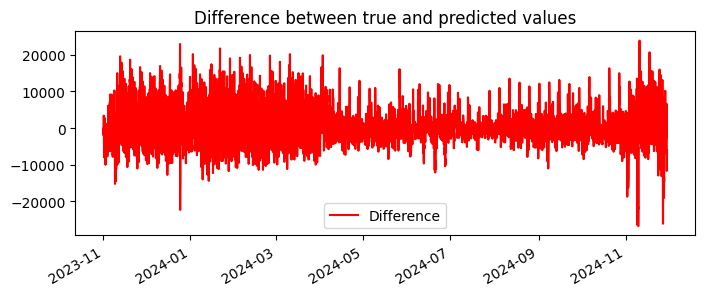

In [22]:
prediction_Theta = pd.read_csv('../Results/Whitebox/Forecasting/ThetaModel_336_24.csv', header=None, index_col=0, names=['Prediction'])
prediction_Theta.index = pd.to_datetime(prediction_Theta.index)

difference = data['ConsumptionkWh'] - prediction_Theta['Prediction']

fig, ax = plt.subplots(figsize=(8, 3))
difference.plot(ax=ax, label='Difference', color='red')
ax.set_title('Difference between true and predicted values')
ax.legend()

Evaluate algorithm performance

In [23]:
def evaluate(prediction, name):
    print(f"-- {name} --")
    print(f"mae: {mean_absolute_error(data, prediction)}")
    print(f"mse: {mean_squared_error(data, prediction)}")
    print(f"rmse: {root_mean_squared_error(data, prediction)}")

data = sample_data(df, date_start)

evaluate(prediction_Theta['Prediction'], 'Theta_model')


-- Theta_model --
mae: 4012.2062463243597
mse: 27559657.56232082
rmse: 5249.729284669907
